In [8]:
# Si usas Google Colab

#from google.colab import drive
#drive.mount("/content/drive")
#import os
#os.chdir("Tu_directorio_de_colab")

Mounted at /content/drive


In [11]:
# Se importan las librerias
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos de entrenamiento
train_data = pd.read_csv('Microsoft_Stock.csv', index_col='Date', parse_dates=True)

In [22]:
train_data.describe()

,Open,High,Low,Close,Volume
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03
mean,107.385976,108.437472,106.294533,107.422091,3.019863e+07
std,56.691333,57.382276,55.977155,56.702299,1.425266e+07
min,40.340000,40.740000,39.720000,40.290000,1.016120e+05
25%,57.860000,58.060000,57.420000,57.855000,2.136213e+07
50%,93.990000,95.100000,92.920000,93.860000,2.662962e+07
75%,139.440000,140.325000,137.825000,138.965000,3.431962e+07
max,245.030000,246.130000,242.920000,244.990000,1.352271e+08


In [23]:
train_data.isna().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0


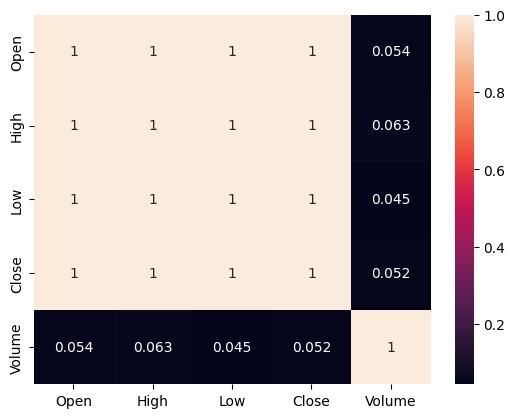

In [24]:
sns.heatmap(train_data.corr(), annot=True)
plt.show()

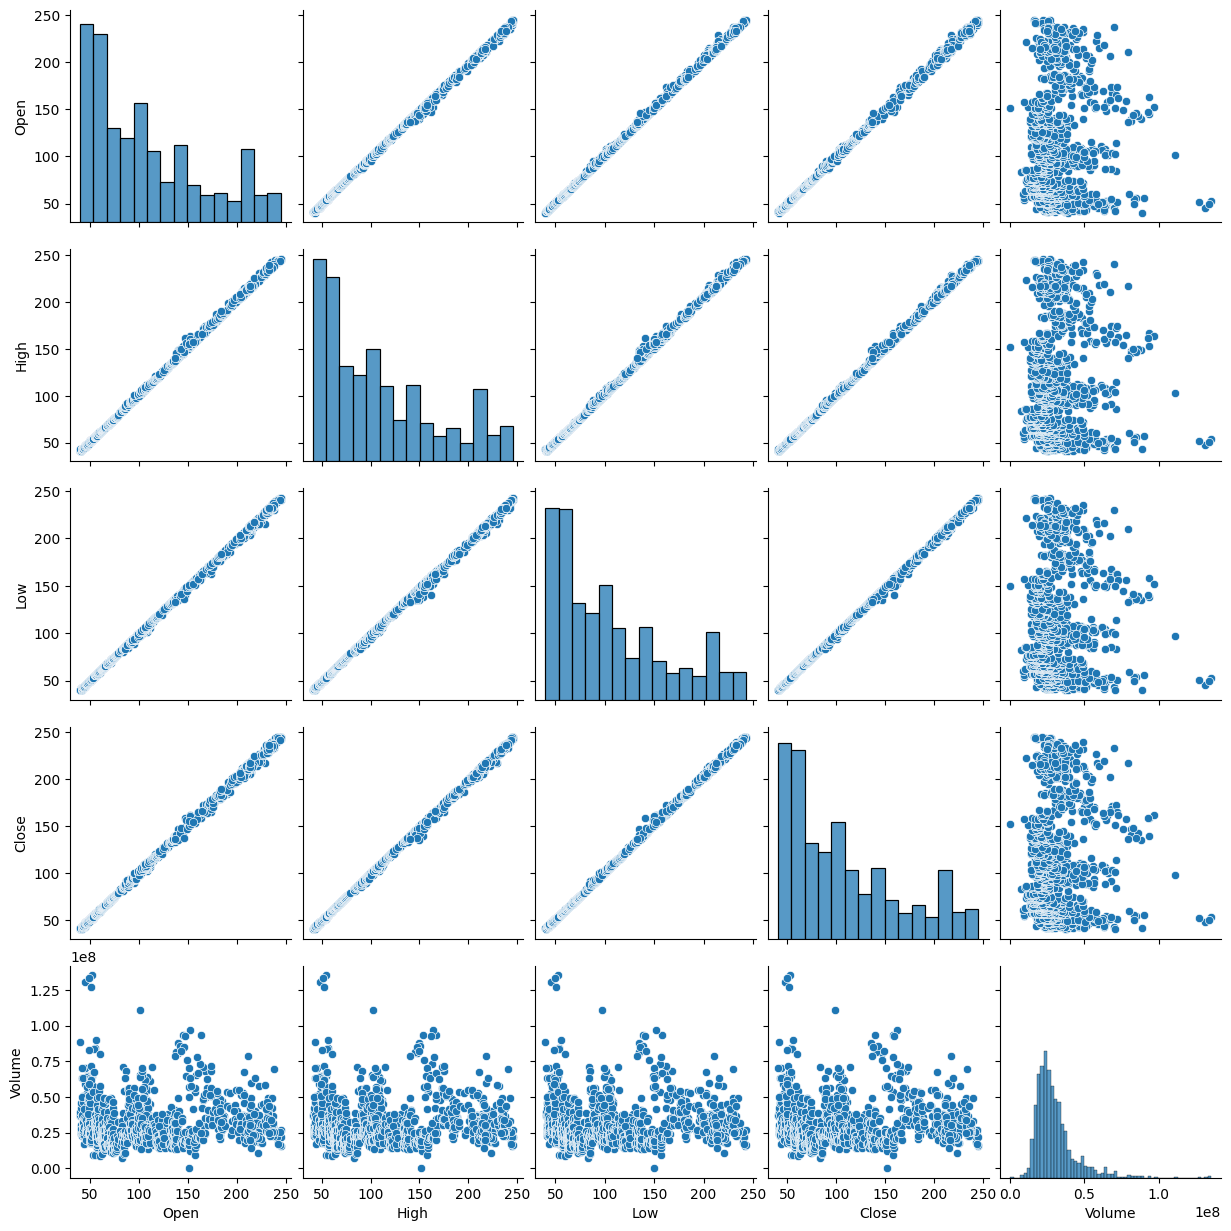

In [26]:
sns.pairplot(train_data)
plt.show()

In [ ]:
#train_data = np.round(train_data)
median = train_data.Open.median()
train_data_or = train_data[train_data['Open'] >=median ][['High','Low','Close']]

In [12]:
# Limpieza de datos
train_data_or.replace(['---', '               ---', 'NaN', '', ' '], np.nan, inplace=True)
imputer = SimpleImputer(strategy='mean')
train_data_or = pd.DataFrame(imputer.fit_transform(train_data_or), columns=train_data_or.columns, index=train_data_or.index)


In [13]:
# Escalado de datos
scaler = MinMaxScaler(feature_range=(0, 1))    ###transforma los datos en ceros y uno
train_scaled = scaler.fit_transform(train_data_or)

# Crear secuencias de temporales, datos para el entrenamiento
def create_dataset(dataset, look_back=60):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

X_train, y_train = create_dataset(train_scaled, 60)


In [14]:
# Modelo LSTM
model = Sequential([
    LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),  #return_sequences=True Devuelve salidas para cada paso (necesario para apilar LSTM)
    Dropout(0.2), #evita el sobreajuste , apaga aleatoriamete el 20% de las neuronas durante el entrenamiento#
    LSTM(100, return_sequences=False), #return sequences = False nos da la salid final y no toda la secuencia
    Dense(1) #capa final densa
])
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 100)             │          41,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,101 (476.96 KB)

 Trainable params: 122,101 (476.96 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 233ms/step - loss: 0.6786
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - loss: 0.0056
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - loss: 0.0016
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 0.0017
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0014
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0014
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.0012
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0014
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0013
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0011
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - loss: 0.0013
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0012
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0011
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0013
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 9.6

In [17]:
# Preparar los datos reales de 2024 para comparación
real_data_2024 = pd.read_csv('Microsoft_Stock.csv', index_col='Date', parse_dates=True)
real_data_2024 = real_data_2024[['High','Low','Close']]
real_data_2024.replace(['---', '               ---', 'NaN', '', ' '], np.nan, inplace=True)
real_data_2024 = pd.DataFrame(imputer.transform(real_data_2024), columns=real_data_2024.columns, index=real_data_2024.index)
real_scaled = scaler.transform(real_data_2024)


In [18]:
# Crear datos de entrada para predicción
X_real, _ = create_dataset(np.vstack([train_scaled[-60:], real_scaled]), 60)

# Predicciones
predictions_scaled = model.predict(X_real)
predictions = scaler.inverse_transform(np.concatenate([predictions_scaled, np.zeros((len(predictions_scaled), 2))], axis=1))[:, 0]

# Datos reales para comparar
real_demand = scaler.inverse_transform(real_scaled)[:, 0]


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step


In [19]:
real_demand

array([ 40.76,  40.74,  41.78, ..., 236.8 , 233.85, 239.1 ])

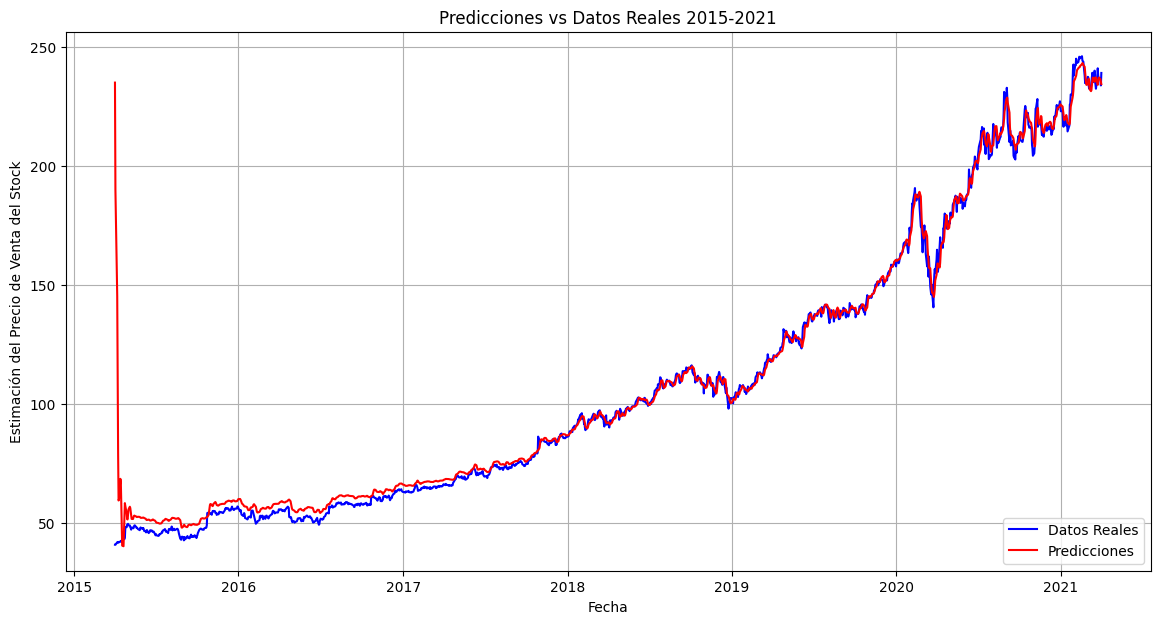

In [28]:

# Graficar
plt.figure(figsize=(14, 7))
plt.plot(real_data_2024.index, real_demand, label='Datos Reales', color='blue')
plt.plot(real_data_2024.index[:len(predictions)], predictions, label='Predicciones', color='red')
plt.title('Predicciones vs Datos Reales 2015-2021')
plt.xlabel('Fecha')
plt.ylabel('Estimación del Precio de Venta del Stock')
plt.legend()
plt.grid(True)
plt.show()


In [30]:

import plotly.graph_objects as go
import pandas as pd
from sklearn.metrics import r2_score

# Asegurarse de que tanto 'real_demand' como 'predictions' tienen el mismo índice de tiempo
real_demand = pd.Series(real_demand[:len(predictions)], index=real_data_2024.index[:len(predictions)])
predictions_series = pd.Series(predictions, index=real_data_2024.index[:len(predictions)])

# Crear una lista para almacenar los R-squared de cada mes
r_squared_monthly = []

# Agrupar los datos por mes y calcular el R-squared para cada mes
for month, group in real_demand.groupby(real_demand.index.month):
    # Extraer las predicciones correspondientes para ese mes
    pred_for_month = predictions_series[group.index]

    # Calcular el R-squared
    r_squared = r2_score(group, pred_for_month)

    # Almacenar el resultado
    r_squared_monthly.append((month, r_squared))
    print(f'R-squared para el mes {month}: {r_squared}')

# Crear la figura usando Plotly para una mejor interactividad y presentación
fig = go.Figure()

# Añadir los datos reales a la gráfica
fig.add_trace(go.Scatter(x=real_data_2024.index, y=real_demand, mode='lines', name='Datos Reales', line=dict(color='blue')))

# Añadir las predicciones a la gráfica
fig.add_trace(go.Scatter(x=real_data_2024.index[:len(predictions)], y=predictions, mode='lines', name='Predicciones', line=dict(color='red')))

# Configuración adicional del gráfico
fig.update_layout(
    title='Comparación de Predicciones vs Datos Reales para el periodo 2015-2021',
    xaxis_title='Fecha',
    yaxis_title='Estimación del Precio de Venta del Stock',
    legend_title='Leyenda'
)

# Mostrar la gráfica
fig.show()

# Imprimir los R-squared mensuales
for month, r_squared in r_squared_monthly:
    print(f"R-squared para el mes {month}: {r_squared:.4f}")

R-squared para el mes 1: 0.9973651549479363
R-squared para el mes 2: 0.9973734877881208
R-squared para el mes 3: 0.9970687360619779
R-squared para el mes 4: 0.6725249530508017
R-squared para el mes 5: 0.9958884689841767
R-squared para el mes 6: 0.9960961906534209
R-squared para el mes 7: 0.9971895393934842
R-squared para el mes 8: 0.9967844087587847
R-squared para el mes 9: 0.9967482668532274
R-squared para el mes 10: 0.9975362795858018
R-squared para el mes 11: 0.9973104388211982
R-squared para el mes 12: 0.9985004431165146


R-squared para el mes 1: 0.9974
R-squared para el mes 2: 0.9974
R-squared para el mes 3: 0.9971
R-squared para el mes 4: 0.6725
R-squared para el mes 5: 0.9959
R-squared para el mes 6: 0.9961
R-squared para el mes 7: 0.9972
R-squared para el mes 8: 0.9968
R-squared para el mes 9: 0.9967
R-squared para el mes 10: 0.9975
R-squared para el mes 11: 0.9973
R-squared para el mes 12: 0.9985
